In [ ]:
print("hello")


hello


In [ ]:
pip install keras


In [ ]:
pip install pillow


In [ ]:
!nvidia-smi


Mon Jul 19 05:08:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install mtcnn


     |████████████████████████████████| 2.3MB 31.2MB/s 


In [ ]:
pip install mtcnn


     |████████████████████████████████| 2.3MB 9.6MB/s 


In [16]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
#from mtcnn import MTCNN
import cv2
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
  image = Image.open(filename)
	# convert to RGB, if needed
  image = image.convert('RGB')
	# convert to array
  pixels = asarray(image)
  grey=cv2.cvtColor(pixels, cv2.cv2.COLOR_RGB2GRAY)
 
	# create the detector, using default weights
  #detector = MTCNN()
	# detect faces in the image
  #results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
  face_detect= cv2.CascadeClassifier("/content/drive/MyDrive/Deep_Learning/haarcascade_frontalface_default.xml")
  faces=face_detect.detectMultiScale(grey)
  p=0
  #face=pixels[y1:y1+h,x1:x1+h]
  for (x,y,w,h) in faces:
    if(p==1):
      break
    x,y=abs(x),abs(y)
    face=pixels[y:y+h,x:x+w]
    p=p+1
	# bug fix
	
	# resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
  faces = list()
	# enumerate files
  for filename in listdir(directory):
		# path
    path = directory + filename
		# get face
    face = extract_face(path)
		# store
    if(not face is None):
      faces.append(face)
  return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
 
# load train dataset
#insert path of folder where training data is present with "/" at last
trainX, trainy = load_dataset('/content/drive/MyDrive/Deep_Learning/105_classes_pins_dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
#insert path of folder where test data is present with "/" at last
testX, testy = load_dataset('/content/drive/MyDrive/Deep_Learning/105_classes_pins_dataset/test/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 82 examples for class: pins_Pedro Alonso
>loaded 142 examples for class: pins_Adriana Lima
>loaded 64 examples for class: pins_Mark Zuckerberg
>loaded 72 examples for class: pins_Bobby Morley
>loaded 117 examples for class: pins_Jason Momoa
>loaded 118 examples for class: pins_Jennifer Lawrence
>loaded 143 examples for class: pins_Megan Fox
>loaded 154 examples for class: pins_Logan Lerman
>loaded 120 examples for class: pins_Chris Pratt
>loaded 120 examples for class: pins_Morena Baccarin
>loaded 108 examples for class: pins_Jeremy Renner
>loaded 99 examples for class: pins_Miley Cyrus
>loaded 161 examples for class: pins_Leonardo DiCaprio
>loaded 113 examples for class: pins_Brie Larson
>loaded 148 examples for class: pins_Sophie Turner
>loaded 127 examples for class: pins_Emilia Clarke
>loaded 132 examples for class: pins_scarlett johansson
>loaded 95 examples for class: pins_Avril Lavigne
>loaded 58 examples for class: pins_Morgan Freeman
>loaded 101 examples for class: pin

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)


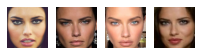

In [5]:
'''
folder = '/content/drive/MyDrive/Deep_Learning/105_classes_pins_dataset/train/pins_Adriana Lima/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
  path = folder + filename
	# get face
  face = extract_face(path)
  if(not face is None):
     print(i, face.shape)
	# plot
     pyplot.subplot(2,7, i)
     pyplot.axis('off')
     pyplot.imshow(face)
     i += 1
     if(i>=5):
       break

pyplot.show()
'''

In [17]:
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('/content/drive/MyDrive/Deep_Learning/Facenet Keras Model/facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (11163, 160, 160, 3) (11163,) (4878, 160, 160, 3) (4878,)
Loaded Model
Cause: could not parse the source code of <function <lambda> at 0x7f3da27ecb00>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f3da27ecb00>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f3da27ec200>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f3da27ec200>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f3da27eca70>: no matching AST found
To silence this warning, deco

In [ ]:
pip install sklearn


In [ ]:
pip install random2

  Created wheel for random2: filename=random2-1.0.1-cp37-none-any.whl size=12071 sha256=107671dec811a033f337cf7f968c13efea71910a5cab9e3b922e729534543f96
  Stored in directory: /root/.cache/pip/wheels/36/a1/eb/8b267e15c260cf21ca104e217f46587db40eaa906cb04d37c0
Successfully built random2


In [ ]:
pip install matplotlib

In [28]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
#from sklearn.svm import SVC
from matplotlib import pyplot
from sklearn.neighbors import KNeighborsClassifier
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = KNeighborsClassifier(n_neighbors=12)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
'''
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()
'''
yhat=model.predict(testX)
from sklearn.metrics import accuracy_score
accuracy_score(testy,yhat)
#from sklearn.metrics import confusion_matrix
#confusion_matrix(testy,yhat)

0.974579745797458